In [1]:
from keras.models import load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Reshape, Flatten,Dropout
from keras.models import Model
from keras.models import load_model

from tensorflow.keras.utils import plot_model
import pydot
import graphviz

In [7]:
!pip install pydot

In [2]:
lstm_model = load_model('lstm_model_withencoder.h5')


In [3]:
encoder=load_model("encoder-simple.h5")

In [4]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 6, 848)]      0         
                                                                 
 flatten (Flatten)           (None, 127200)            0         
                                                                 
 dense (Dense)               (None, 256)               32563456  
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 100)               12900     
                                                                 
 dense_3 (Dense)             (None, 1600)              161600    
                                                                 
Total params: 32,770,852
Trainable params: 32,770,852
Non-t

In [5]:

input_shape = (25,6,848)

input_layer = Input(shape=(input_shape))
hidden_layer_0=encoder(input_layer)
hidden_layer_1 =Reshape((25,64))(hidden_layer_0)
output_layer = lstm_model(hidden_layer_1)

model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='mse')

In [6]:
X2=np.load("X2.npy")
Y2=np.load("Y2.npy",allow_pickle=True)

In [7]:
predicted_y=model.predict(X2)

655/655 [==============================] - 10s 15ms/step


In [8]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(Y2,predicted_y)

0.9274228886150907

In [9]:
model.save("combined_model_lstm_encoder.h5")

# the prediction procuss

In [94]:
model=load_model("combined_model_lstm_encoder.h5")

In [95]:
model_cnn=load_model("Cnn_lstm_model.h5")

In [96]:
test_data=np.load("test_data.npy",allow_pickle=True)

In [97]:
min_max=np.load("min_max.npy")

In [98]:
x=test_data[17].drop(["SOH","charge_policy"],axis=1)
y=test_data[17]["SOH"]

In [99]:
def normalization(x,min_max):
    t=np.zeros((len(x),6,848))
    for i in range(len(x)):
        x["Ic"][i]= (x["Ic"][i]-min_max[0])/(min_max[1]-min_max[0])
        x["Id"][i]= (x["Id"][i]-min_max[2])/(min_max[3]-min_max[2])
        x["Vc"][i]= (x["Vc"][i]-min_max[4])/(min_max[5]-min_max[4])
        x["Vd"][i]= (x["Vd"][i]-min_max[6])/(min_max[7]-min_max[6])
        x["Tc"][i]= (x["Tc"][i]-min_max[8])/(min_max[9]-min_max[8])
        x["Td"][i]= (x["Td"][i]-min_max[10])/(min_max[11]-min_max[10])
        t[i][0][0:len(x["Ic"][i])]=x["Ic"][i]
        t[i][1][0:len(x["Id"][i])]=x["Id"][i]
        
        t[i][2][0:len(x["Vc"][i])]=x["Vc"][i]
        t[i][3][0:len(x["Vd"][i])]=x["Vd"][i]
        
        t[i][4][0:len(x["Tc"][i])]=x["Tc"][i]
        t[i][5][0:len(x["Td"][i])]=x["Td"][i]
    
    return t

In [100]:
x=normalization(x,min_max)

In [101]:
def prepare_data(x):
    data=[]
    for i in range(len(x)):
        if(i+10<len(x)):
            data.append(x[i:i+10])
    return data

In [102]:
yp_cnn=[]
yp_lstm=[]
x=prepare_data(x)
yp_cnn.append(model_cnn.predict(np.reshape(x[0],(1,10,6,848))))
yp_lstm.append(model.predict(np.reshape(x[0],(1,10,6,848))))
for i in range(1,len(x),1):
    o=model_cnn.predict(np.reshape(x[i],(1,10,6,848)))
    yp_cnn.append(o[0][9])
    o=model.predict(np.reshape(x[i],(1,10,6,848)))
    yp_lstm.append(o[0][9])

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


In [103]:

yp_cnn=np.concatenate((yp_cnn[0][0], yp_cnn[1:len(yp_cnn)]), axis=0)
yp_lstm=np.concatenate((yp_lstm[0][0], yp_lstm[1:len(yp_lstm)]), axis=0)

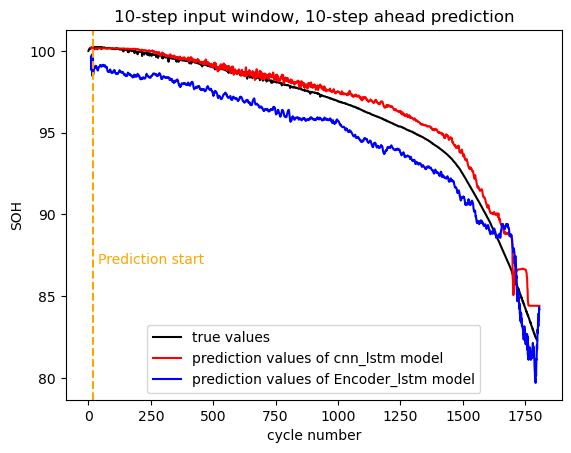

In [106]:
fig, ax = plt.subplots()
plt.plot(y,color="black",label="true values")
plt.plot(range(10,len(yp_cnn)+10,1),yp_cnn,label="prediction values of cnn_lstm model",color="red")
plt.plot(range(10,len(yp_lstm)+10,1),yp_lstm,label="prediction values of Encoder_lstm model",color="blue")
plt.axvline(x=18,color='orange', linestyle='--')
plt.text(38, 87, 'Prediction start',color="orange")
plt.legend()
plt.xlabel("cycle number")
plt.ylabel("SOH")
plt.title("10-step input window, 10-step ahead prediction")
fig.savefig("sohprediction.pdf", format="pdf", dpi=1200)

# evaluation

In [27]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [56]:
from sklearn import metrics
yhat=Y2
y1=model.predict(X2)
ycnn=model_cnn.predict(X2)

mael = metrics.mean_absolute_error(y1, yhat)
maecnn = metrics.mean_absolute_error(ycnn, yhat)
mse1 = metrics.mean_squared_error(y1, yhat)
msecnn = metrics.mean_squared_error(ycnn, yhat)
rmse1 = np.sqrt(mse1)
rmsecnn = np.sqrt(msecnn)# or mse**(0.5)  


print("Results of sklearn.metrics:")
print("MAE lstm:",mael)
print("MAE cnn:",maecnn)
print("MSE lstm:", mse1)
print("MSE cnn:", msecnn)
print("RMSE lstm:", rmse1)
print("RMSE cnn:", rmsecnn)
 


655/655 [==============================] - 12s 17ms/step
Results of sklearn.metrics:
MAE lstm: 0.9274228886150907
MAE cnn: 1.0765427246024277
MSE lstm: 1.270930599014405
MSE cnn: 4.01472670233554
RMSE lstm: 1.1273555778965239
RMSE cnn: 2.003678293123809


In [13]:
MAPEL=MAPE(y1,Y2)
MAPEcnn=MAPE(ycnn,Y2)
print("MAPE lstm: ",MAPEL)
print("MAPE cnn: ",MAPEcnn)
print("std lstm: ",np.std(y1))
print("std cnn: ",np.std(ycnn))

MAPE lstm:  1.1322671673466511
MAPE cnn:  1.5313750163864897
std lstm:  3.666496
std cnn:  4.558502
